# 1. Introdução

Neste projeto utilizei um dataset de transações financeiras para prever fraudes. Coletei uma amostra do dataset original onde preservei o percentual da quantidade de fraudes, realizei uma análise exploratória para identificar padrões e discrepâncias entre transações legítimas e fraudulentas. Com base nessas informações, desenvolvi um modelo de machine learning para identificar possíveis fraudes, auxiliando na prevenção de perdas financeiras.

# 2. Carregando bibliotecas

In [55]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     cross_val_score)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.discretisation import EqualWidthDiscretiser
from feature_engine.selection import RecursiveFeatureElimination
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (accuracy_score,
                             roc_auc_score,
                             f1_score,
                             precision_score,
                             recall_score,
                             confusion_matrix)

# 3. Analisando estrutura do dataset

In [5]:
df = pd.read_csv('C:/Users/joema/Datasets/credit_card_transactions.csv')

In [6]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [7]:
print(f'O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas')

O dataset possui 1296675 linhas e 24 colunas


In [8]:
df.isna().sum()

Unnamed: 0                    0
trans_date_trans_time         0
cc_num                        0
merchant                      0
category                      0
amt                           0
first                         0
last                          0
gender                        0
street                        0
city                          0
state                         0
zip                           0
lat                           0
long                          0
city_pop                      0
job                           0
dob                           0
trans_num                     0
unix_time                     0
merch_lat                     0
merch_long                    0
is_fraud                      0
merch_zipcode            195973
dtype: int64

In [9]:
df = df.drop(columns = ['merch_zipcode'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [11]:
df.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
first                        352
last                         481
gender                         2
street                       983
city                         894
state                         51
zip                          970
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
unix_time                1274823
merch_lat                1247805
merch_long               1275745
is_fraud                       2
dtype: int64

In [12]:
df['is_fraud'].value_counts(normalize = True)

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

In [13]:
df['amt'].describe()

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [17]:
transactions = df.sample(frac = 0.2)

In [18]:
print(f'A amostra do dataset possui {transactions.shape[0]} linhas e {transactions.shape[1]} colunas')

A amostra do dataset possui 259335 linhas e 23 colunas


In [19]:
transactions['is_fraud'].value_counts(normalize = True)

is_fraud
0    0.994197
1    0.005803
Name: proportion, dtype: float64

In [20]:
transactions['amt'].describe()

count    259335.000000
mean         70.375639
std         156.049051
min           1.000000
25%           9.640000
50%          47.420000
75%          83.040000
max       15034.180000
Name: amt, dtype: float64

# 4. Análise exploratória (EDA)

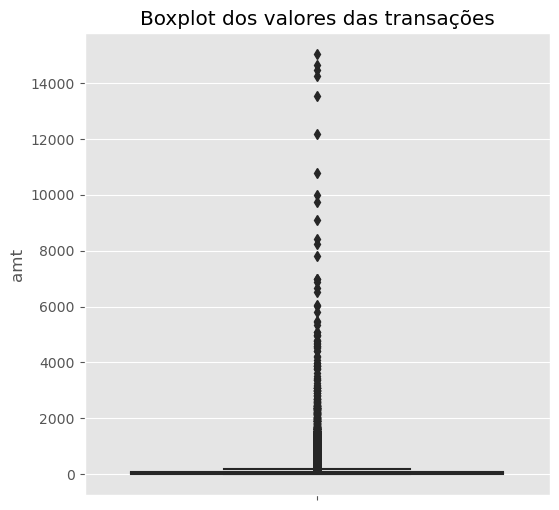

In [21]:
plt.figure(figsize = (6, 6))

sns.boxplot(y = 'amt', data = transactions, color = 'purple')
plt.title('Boxplot dos valores das transações')

plt.show()

In [22]:
gender_churn = transactions.groupby(['gender', 'is_fraud'])['is_fraud'].count()

In [23]:
gender_churn

gender  is_fraud
F       0           141094
        1              749
M       0           116736
        1              756
Name: is_fraud, dtype: int64

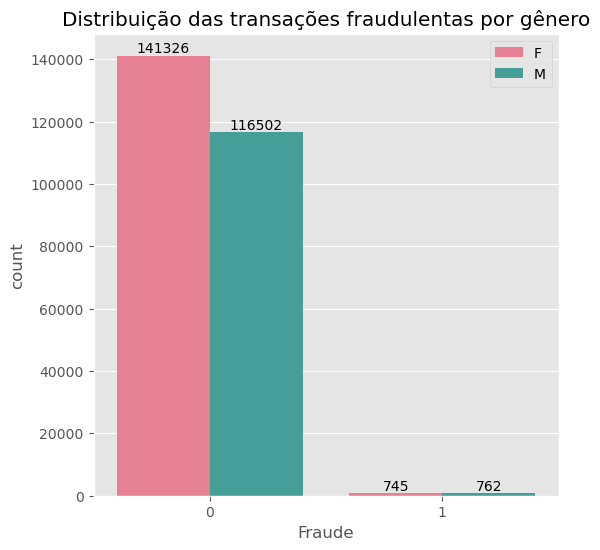

In [28]:
plt.figure(figsize = (6, 6))

sns.countplot(hue = 'gender', x = 'is_fraud', data = transactions, palette = 'husl')
plt.title('Distribuição das transações fraudulentas por gênero')
plt.xlabel('Fraude')
plt.legend()

plt.text(0.2, 116502, str(116502), ha = 'center', va = 'bottom')
plt.text(-0.2, 141326, str(141326), ha = 'center', va = 'bottom')
plt.text(0.8, 745, str(745), ha = 'center', va = 'bottom')
plt.text(1.2, 762, str(762), ha = 'center', va = 'bottom')

plt.show()

In [29]:
city_churn = transactions.groupby(['city', 'is_fraud'])['is_fraud'].count().unstack()

city_churn = city_churn.fillna(0)

In [30]:
top_city_churn = city_churn[city_churn[0].values < 20].sort_values(ascending = False, by = 1)[:15][1]

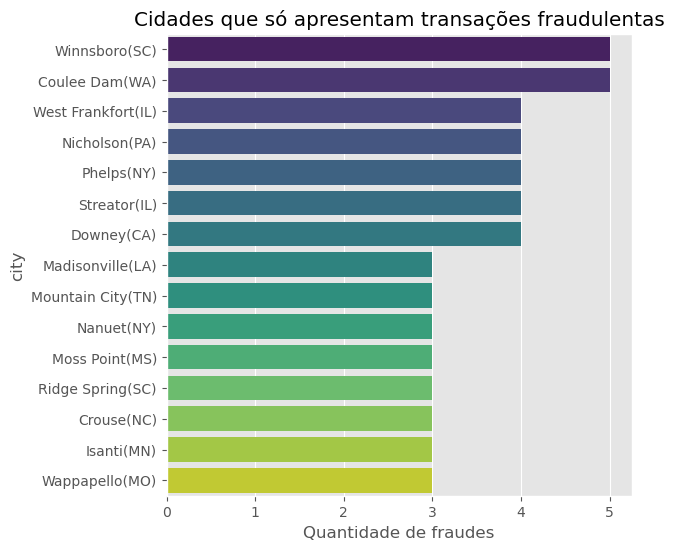

In [31]:
plt.figure(figsize = (6, 6))

sns.barplot(y = top_city_churn.index, x = top_city_churn.values, palette = 'viridis')
plt.title('Cidades que só apresentam transações fraudulentas')
plt.xlabel('Quantidade de fraudes')

ticks = range(15)
citys_state = []

for ci in top_city_churn.index:
    citys_state.append(f"{ci}({transactions.query('city == @ci')['state'].unique()[0]})")

plt.yticks(ticks = ticks, labels = citys_state)

plt.show()

Identificamos um padrão alarmante, várias cidades estão enfrentando um problema significativo com fraudes, sem registrar nenhuma transação legal. Isso é preocupante, pois indica que estas cidades podem estar sendo exploradas por atividades fraudulentas sem qualquer compensação positiva.

In [32]:
state_churn = transactions.groupby(['state', 'is_fraud'])['is_fraud'].count().unstack()

state_churn = state_churn.fillna(0)

In [33]:
state_churn.sort_values(ascending = False, by = 1)

is_fraud,0,1
state,,
NY,16606.0,107.0
PA,15876.0,91.0
TX,18780.0,90.0
CA,11149.0,68.0
OH,9211.0,66.0
FL,8493.0,57.0
IL,8598.0,54.0
MI,9173.0,52.0
AL,7975.0,46.0


In [34]:
top_state_churn = state_churn.sort_values(ascending = False, by = 1)[:15][1]

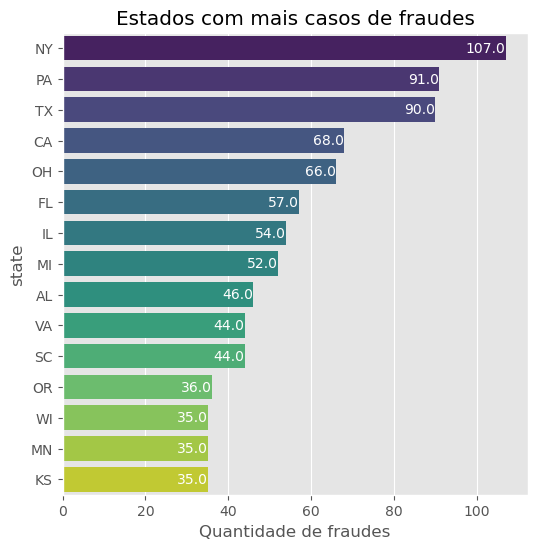

In [35]:
plt.figure(figsize = (6, 6))

sns.barplot(y = top_state_churn.index, x = top_state_churn.values, palette = 'viridis')
plt.title('Estados com mais casos de fraudes')
plt.xlabel('Quantidade de fraudes')

for i, v in enumerate(top_state_churn.values):
    plt.text(v, i, str(v), ha = 'right', va = 'center', color = 'white')

plt.show()

Estes são os estados com mais transações fraudulentas, o que foi de se esperar já que são os que mais possuem transações. Ao olhar a tabela de estados e suas transações notasse que temos 2 estados com pouquíssimas transações e um número de fraudes significante, os estados RI e DE, essa informação pode nos ajudar muito a detectar possíveis fraudes.

In [36]:
category_churn = transactions.groupby(['category', 'is_fraud'])['is_fraud'].count().unstack()

category_churn = category_churn.fillna(0).sort_values(ascending = False, by = 1)[1]

In [37]:
category_churn

category
grocery_pos       360
shopping_net      344
misc_net          195
shopping_pos      159
gas_transport     106
misc_pos           53
personal_care      51
kids_pets          46
home               39
entertainment      38
grocery_net        31
travel             31
health_fitness     27
food_dining        25
Name: 1, dtype: int64

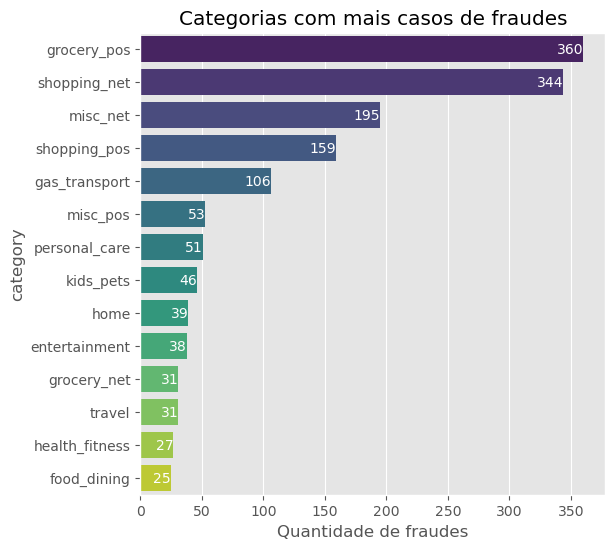

In [38]:
plt.figure(figsize = (6, 6))

sns.barplot(y = category_churn.index, x = category_churn.values, palette = 'viridis')
plt.title('Categorias com mais casos de fraudes')
plt.xlabel('Quantidade de fraudes')

for i, v in enumerate(category_churn.values):
    plt.text(v, i, str(v), ha = 'right', va = 'center', color = 'white')

plt.show()

Com certeza a categoria influencia muito na probabilidade de fraude, com destaque nas categorias 'grocery_pos', 'shopping_net', 'misc_net' e 'shopping_pos' com mais de 15 fraudes cada.

In [39]:
churn_amt = transactions[transactions['is_fraud'] == 1]['amt']

no_churn_amt = transactions[transactions['is_fraud'] == 0]['amt']

In [40]:
churn_amt.describe()

count    1505.000000
mean      527.696166
std       389.723349
min         1.910000
25%       242.240000
50%       374.080000
75%       893.570000
max      1294.830000
Name: amt, dtype: float64

In [41]:
no_churn_amt.describe()

count    257830.000000
mean         67.706177
std         149.597892
min           1.000000
25%           9.590000
50%          47.200000
75%          82.430000
max       15034.180000
Name: amt, dtype: float64

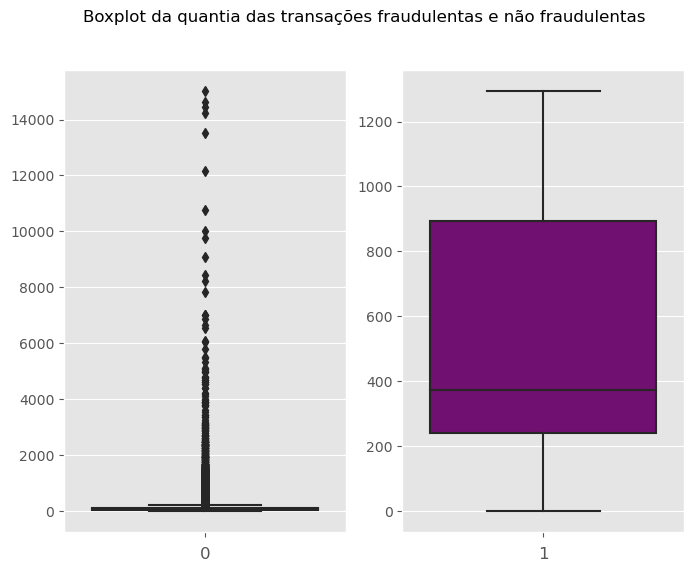

In [42]:
fig, axs = plt.subplots(1, 2, figsize = (8, 6))

for i, data in enumerate([no_churn_amt, churn_amt]):
    sns.boxplot(y = data.values, color = 'purple', ax = axs[i])
    axs[i].set_xlabel(i)

plt.suptitle('Boxplot da quantia das transações fraudulentas e não fraudulentas')

plt.show()

A maioria das fraudes ocorrem quando a quantia da transação está entre 130 e 890, certamente isso será de grande ajuda ao nosso modelo preditivo

In [43]:
cc_num_churn = transactions.groupby(['cc_num', 'is_fraud'])['is_fraud'].count().unstack()

cc_num_churn = cc_num_churn.fillna(0).sort_values(ascending = False, by = 1)

cc_num_churn['total'] = cc_num_churn[0] + cc_num_churn[1]

In [44]:
statistic_cc_num_churn = cc_num_churn.groupby(1)['total'].agg(['mean', 'median', 'min', 'max'])

In [45]:
statistic_cc_num_churn

,mean,median,min,max
1,,,,
0.0,283.766562,281.0,70.0,645.0
1.0,246.407960,215.0,1.0,658.0
2.0,254.788462,218.5,2.0,642.0
3.0,258.540000,229.0,3.0,643.0
4.0,279.816901,289.0,4.0,650.0
5.0,277.291667,247.5,5.0,606.0
6.0,358.000000,358.0,327.0,389.0
7.0,366.500000,366.5,301.0,432.0
8.0,105.000000,105.0,105.0,105.0


Com essas estatísticas podemos ver como a quantidade de compras que um cartão de crédito fez influencia na probabilidade de uma possível fraude. Quando um cartão tem pouquíssimas compras realizadas é um indício de que é uma possível fraude, um contraponto é que se uma pessoa que nunca fez uma compra nesta empresa vai fazer uma transação pelo cartão de crédito não necessariamente é uma fraude, apenas é sua primeira vez no estabelecimento.

# 5. Feature engineering / selection

In [46]:
X = transactions.drop(columns = ['is_fraud', 'Unnamed: 0', 'trans_date_trans_time'])

y = transactions['is_fraud']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('count_frequency_encoder', CountFrequencyEncoder(encoding_method = 'frequency'), ['cc_num', 'merchant', 'city', 'state', 'job']),
        ('one_hot_encoder', OneHotEncoder(drop = 'if_binary'), ['gender', 'category']),
        ('equal_width_discretiser', EqualWidthDiscretiser(bins = 30), ['amt']),
        ('log_transformer', LogTransformer(), ['city_pop']),
        ('scaler', StandardScaler(), ['amt', 'city_pop'])
    ],

)

In [67]:
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('recursive_feature_elimination', RecursiveFeatureElimination(estimator = xgb.XGBClassifier(),
                                                                 scoring = 'recall',
                                                                 threshold = 0.05,
                                                                 cv = 3)),
    ('model', xgb.XGBClassifier())
])

# 6. Treinando e validando modelo preditivo

In [68]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('count_frequency_encoder',
                                                  CountFrequencyEncoder(encoding_method='frequency'),
                                                  ['cc_num', 'merchant', 'city',
                                                   'state', 'job']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'category']),
                                                 ('equal_width_discretiser',
                                                  EqualWidthDiscretiser(bins=30),
                                                  ['amt']),
                                                 ('log_transformer',
                                                  LogT...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

### Primeira validação

In [69]:
y_pred = pipeline.predict(X_test)

In [70]:
print(f'Acurácia: {accuracy_score(y_test, y_pred):.2f}')
print(f'Recall Score: {recall_score(y_test, y_pred):.2f}')
print(f'Precision Score: {precision_score(y_test, y_pred):.2f}')
print(f'F1-Score: {f1_score(y_test, y_pred):.2f}')
print(f'Roc-Auc-Score: {roc_auc_score(y_test, y_pred):.2f}')

Acurácia: 1.00
Recall Score: 0.59
Precision Score: 0.75
F1-Score: 0.66
Roc-Auc-Score: 0.79


In [71]:
confusion = confusion_matrix(y_test, y_pred)

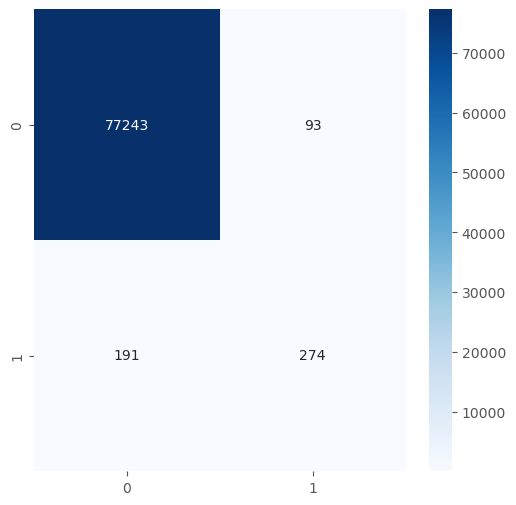

In [72]:
plt.figure(figsize = (6, 6))

sns.heatmap(confusion, annot = True, fmt = 'd', cmap = 'Blues')

plt.show()

### Ajustando parâmetros

In [96]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

y_pred_adjusted = (y_proba >= 0.001).astype(int)

confusion_ajusted = confusion_matrix(y_test, y_pred_adjusted)

In [97]:
print(f'Acurácia: {accuracy_score(y_test, y_pred_adjusted):.2f}')
print(f'Recall Score: {recall_score(y_test, y_pred_adjusted):.2f}')
print(f'Precision Score: {precision_score(y_test, y_pred_adjusted):.2f}')
print(f'F1-Score: {f1_score(y_test, y_pred_adjusted):.2f}')
print(f'Roc-Auc-Score: {roc_auc_score(y_test, y_pred_adjusted):.2f}')

Acurácia: 0.77
Recall Score: 0.96
Precision Score: 0.02
F1-Score: 0.05
Roc-Auc-Score: 0.86


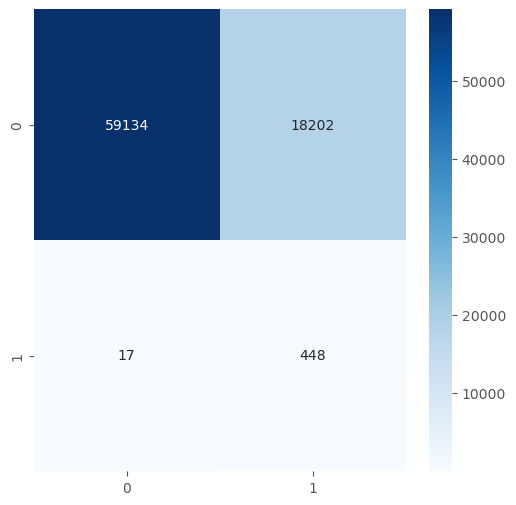

In [98]:
plt.figure(figsize = (6, 6))

sns.heatmap(confusion_ajusted, annot = True, fmt = 'd', cmap = 'Blues')

plt.show()

### Validação cruzada

In [99]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

cv_recalls = cross_val_score(pipeline, X_train, y_train, cv = kf, scoring = 'recall')

In [100]:
cv_recalls

array([0.515     , 0.60663507, 0.59693878, 0.5915493 , 0.46818182])

### Testando modelo para o dataset original

In [101]:
X_total = df.drop(columns = ['is_fraud'])

y_total = df['is_fraud']

In [102]:
y_pred_total = pipeline.predict(X_total)

In [124]:
y_proba_total = pipeline.predict_proba(X_total)[:, 1]

y_pred_total_adjusted = (y_proba_total >= 0.001).astype(int)

confusion_ajusted = confusion_matrix(y_total, y_pred_total_adjusted)

In [125]:
print(f'Acurácia: {accuracy_score(y_total, y_pred_total_adjusted):.2f}')
print(f'Recall Score: {recall_score(y_total, y_pred_total_adjusted):.2f}')
print(f'Precision Score: {precision_score(y_total, y_pred_total_adjusted):.2f}')
print(f'F1-Score: {f1_score(y_total, y_pred_total_adjusted):.2f}')
print(f'Roc-Auc-Score: {roc_auc_score(y_total, y_pred_total_adjusted):.2f}')

Acurácia: 0.77
Recall Score: 0.98
Precision Score: 0.02
F1-Score: 0.05
Roc-Auc-Score: 0.87


In [126]:
confusion_total = confusion_matrix(y_total, y_pred_total_adjusted)

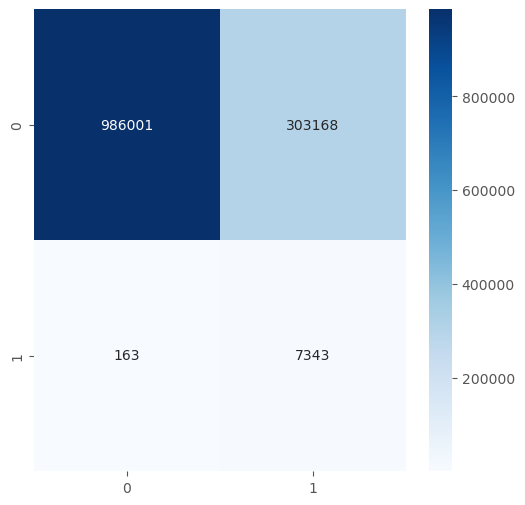

In [127]:
plt.figure(figsize = (6, 6))

sns.heatmap(confusion_total, annot = True, fmt = 'd', cmap = 'Blues')

plt.show()